 # ResNet 50, 101 layer 

## Import Package

필요한 패키지를 import 시켜야합니다 여기서 사용할 패키지는 아래와 같습니다  
You need to import the required packages. Here are the packages to use

In [1]:
import numpy as np
import tensorflow as tf
import keras
# *으로 가져오는것은 권장하지 않습니다.
# Importing into * is not recommended.
from keras.layers import ZeroPadding2D, Conv2D,BatchNormalization,MaxPool2D, Dense, LeakyReLU, Add, GlobalAveragePooling2D,Softmax,Input
from keras.losses import sparse_categorical_crossentropy, binary_crossentropy
from keras.models import Model
from keras.optimizers import Adam,Nadam
from keras import backend as K
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


Deep Residual Learning for Image Recognition 논문(https://arxiv.org/abs/1512.03385) 을 보면 Plain Net에 진행중인 레이어의  
가중치를 저장한 후 한 세트의 ConvNet를 만들고 저장한 가중치를 연결하는 방법을 사용하여 vanishing gradient 현상을 완화 한것으로 보입니다.  
 
각 레이어 길이 별로 다음과 같은 형태를 가집니다.  
Each layer length has the following shape:

![image](image/1.png)

## First Convolution Network
![image](image/3.png)

첫번째 ConvNet은 레이어 길이에 관계없이 7x7 커널크기에 64채널과  stride 2로 구성되어있습니다.  
The first ConvNet is a 7x7 kernel with 64 channels and stride 2, regardless of layer length.

그 다음 플링 레이어 strid 2를 만들어 줍니다  
then next the Pooling layer and stride 2.  
***

In [2]:
def InputBlock(input_tensor):
    conv1_padding = ZeroPadding2D((3,3))(input_tensor)
    conv1_conv = Conv2D(64,7,strides=(2,2))(conv1_padding)
    conv1_bn = BatchNormalization()(conv1_conv)
    # 여기서는  ReLU 대신 LeakyReLU으로 구현해 봅니다.
    # We will implement LeakyReLU instead of ReLU here.
    conv1_relu = LeakyReLU()(conv1_bn) 
    return conv1_relu

def PoolingLayer(x):
    pool1_padding = ZeroPadding2D()(x)
    pool1_pool = MaxPool2D((3,3),2)(pool1_padding)    
    return pool1_pool

## First Convolution Network
![image](image/4.png)

In [3]:
# x:  입력 레이어를 입력합니다..
# filters: ConvNet의 필터 갯수를 리스트로 입력합니다
#           example : 64,64,256 => [ 64,64,256 ]
# kernel_size: 커널 크기를 리스트 형태로 입력합니다 
#           example 1x1, 3x3, 1x1 => [ 1,3,1]
# block_count: 반복할 횟수를 지정합니다 1번 반복 후  Residual을 합니다.
# first_conv_divesion (defult: True) : 첫번째 ConvNet의 stride를 2x2 크기로 주어 입력 크기를 감소시킵니다 
def ResidualBlock(x, filters, kernel_size, block_count, first_conv_padding = True):
    if(len(filters) != len(kernel_size)) :
        raise ValueError("filters count and kernel_size count must be the same(Filter:%d, Kernal: %d)"%(len(filters), len(kernel_size)))
    if (len(kernel_size)==0 or len(filters)==0):
        raise ValueError("Have not entered value")
    
    shortcut = x
    residual_conv= True #첫번째 residual에 ConvNet을 추가합니다
    for i in range(block_count):
        if residual_conv == True:            
            if first_conv_padding:
                shortcut = Conv2D(filters[-1],kernel_size[-1],strides=2,padding='same')(shortcut)
            else:
                shortcut = Conv2D(filters[-1],kernel_size[-1],padding='same')(shortcut)
            shortcut = BatchNormalization()(shortcut)
            residual_conv = False
        
        if first_conv_padding:
            x = Conv2D(filters[0],kernel_size[0],strides=2, padding='same')(x)
            first_conv_padding = False
        else:
            x = Conv2D(filters[0],kernel_size[0],padding='same' )(x)            
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)

        x = Conv2D(filters[1],kernel_size[1],padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)

        if len(filters)==3:
            x = Conv2D(filters[2],kernel_size[2])(x)
            x = BatchNormalization()(x)
        x = Add()([x,shortcut])
        x = LeakyReLU()(x)
        shortcut = x
    return x

ResNet 50 layer는 64,512필터의 ConvNet층 3개,128,1024필터의 ConvNet층 4개,512,1024필터의 ConvNet층 6개,512,2048필터의 ConvNet층 3개를 가집니다.  
The ResNet 50 layer has three ConvNet layers of 64,512 filters, four ConvNet layers of 128,1024 filters, six ConvNet layers of 512,1024 filters, and three ConvNet layers of 512,2048 filters.  

  
ResNet 101 레이어도 4번째 ConvNet층이 23개이며. 다른 부분은 ResNet 50과 같습니다  
The ResNet 101 layer also has 23 4th ConvNet layers. The other part is the same as ResNet 50

In [4]:
K.clear_session() 
def ResNet18(inputs):    
    conv1 = InputBlock(inputs)
    pooling = PoolingLayer(conv1)
    conv2 = ResidualBlock(pooling,filters=[64,64], kernel_size=[3,3], block_count=2,first_conv_padding=False)
    conv3 = ResidualBlock(conv2,filters=[128,128], kernel_size=[3,3], block_count=2)
    conv4 = ResidualBlock(conv3,filters=[256,256], kernel_size=[3,3], block_count=2)
    conv5 = ResidualBlock(conv4,filters=[512,512], kernel_size=[3,3], block_count=2)
 
    return conv5

def ResNet34(inputs):    
    conv1 = InputBlock(inputs)
    pooling = PoolingLayer(conv1)
    conv2 = ResidualBlock(pooling,filters=[64,64], kernel_size=[3,3], block_count=3,first_conv_padding=False)
    conv3 = ResidualBlock(conv2,filters=[128,128], kernel_size=[3,3], block_count=4)
    conv4 = ResidualBlock(conv3,filters=[256,256], kernel_size=[3,3], block_count=6)
    conv5 = ResidualBlock(conv4,filters=[512,512], kernel_size=[3,3], block_count=3)
 
    return conv5


def ResNet50(inputs):    
    conv1 = InputBlock(inputs)
    pooling = PoolingLayer(conv1)
    conv2 = ResidualBlock(pooling,filters=[64,64,256], kernel_size=[1,3,1], block_count=3,first_conv_padding=False)
    conv3 = ResidualBlock(conv2,filters=[128,128,512], kernel_size=[1,3,1], block_count=4)
    conv4 = ResidualBlock(conv3,filters=[256,256,1024], kernel_size=[1,3,1], block_count=6)
    conv5 = ResidualBlock(conv4,filters=[512,512,2048], kernel_size=[1,3,1], block_count=3)
 
    return conv5

def ResNet101(inputs):    
    conv1 = InputBlock(inputs)
    pooling = PoolingLayer(conv1)
    conv2 = ResidualBlock(pooling,filters=[64,64,256], kernel_size=[1,3,1], block_count=3,first_conv_padding=False)
    conv3 = ResidualBlock(conv2,filters=[128,128,512], kernel_size=[1,3,1], block_count=4)
    conv4 = ResidualBlock(conv3,filters=[256,256,1024], kernel_size=[1,3,1], block_count=23)
    conv5 = ResidualBlock(conv4,filters=[512,512,2048], kernel_size=[1,3,1], block_count=3)
 
    return conv5

In [5]:
inputs =  Input(shape=(224,224,3))

x = ResNet50(inputs) 

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
print( 'Make Model Parameter: %d'%Model(inputs,x).count_params())

Make Model Parameter: 23587712


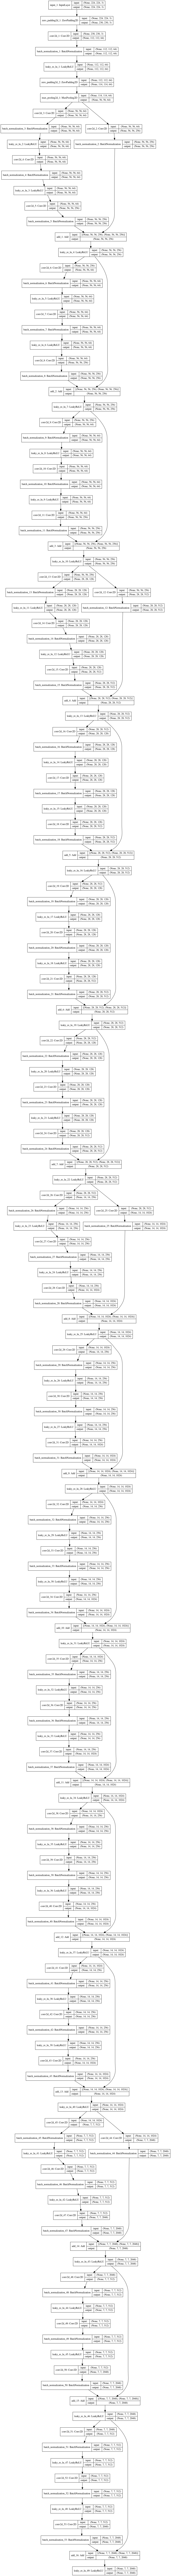

In [7]:
plot_model(Model(inputs,x), to_file='./image/model_plot.png', show_shapes=True, show_layer_names=True)

#Training Model

In [8]:
import matplotlib.pyplot as plt 

def HistoryShow(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    total_epoch = [i for i in range(1,len(loss)+1)]

    plt.plot(total_epoch,loss,'ro',label='Training loss')
    plt.plot(total_epoch,val_loss,'b',label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
from keras.datasets import cifar10
import pickle as pk

K.clear_session()
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32')
x_train /= 255

x_test = x_test.astype('float32')
x_test /= 255

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

inputs =  Input(shape=(32,32,3))
x = ResNet18(inputs) 
x = GlobalAveragePooling2D()(x)
x = Dense(1000)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dense(10)(x)
x = Softmax()(x)

model = Model(inputs,x)
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['acc'])

hist = model.fit(x_train,y_train,
          epochs=50, 
          batch_size=32,
          verbose=1,
          validation_data=(x_test, y_test), 
                )

with open('histRes18.pk','wb') as f:
    pk.dump(hist,f)

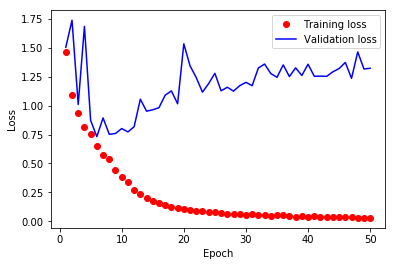

In [11]:
with open('histRes18.pk','rb') as f:
    hist = pk.load(f)
    HistoryShow(hist)

In [ ]:
K.clear_session()
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32')
x_train /= 255

x_test = x_test.astype('float32')
x_test /= 255

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

inputs =  Input(shape=(32,32,3))
x = ResNet18(inputs) 
x = GlobalAveragePooling2D()(x)
x = Dense(1000)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dense(10)(x)
x = Softmax()(x)

model = Model(inputs,x)
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['acc'])

hist = model.fit(x_train,y_train,
          epochs=50, 
          batch_size=32,
          verbose=1,
          validation_data=(x_test, y_test), 
                )

with open('histRes34.pk','wb') as f:
    pk.dump(hist,f)

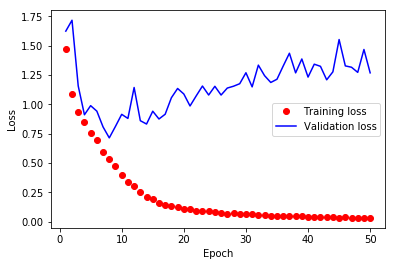

In [12]:
with open('histRes34.pk','rb') as f:
    hist = pk.load(f)
    HistoryShow(hist)